# Tracing career histories of film directors from IMDb data

This notebook is the start of a journey to answer a key question: Can social networks, particularly through connections with network brokers, pave the way for longer and more prolific careers for women movie directors? And does this network effect differ from their men counterparts?

**Why should we care?**

This project is inspired by a puzzling finding in social capital research. Typically, being a network broker — a person who connects different social circles — is associated with career advancement. However, this doesn't seem to hold true for women. In fact, evidence suggests that such roles might actually impede women's careers. For my PhD dissertation, I want to explore an alternative pathway for women to harness the power of brokerage networks - by forming connections to network brokers. 

**How do we do this?**

This notebook walks through the first phase of the project: constructing  a unique dataset of first-time movie directors, collecting data on their career trajectories and collaborations with other film-makers. This lays the ground work for the second phase: calculating these directors' levels of brokerage social capital and those of their collaborators over time. 

We'll look at the collaboration networks of film-makers from 2000 to 2023. I chose this era due to the spread of the internet in the late 90s, which significantly changed the way people collaborate to make movies. 

We'll predict career longevity for directors who made their first movie betweem 2003 and 2013. Brokerage scores are calculated using a 3-year moving window. This means that for any given year, a filmmaker's brokerage score is derived from their collaboration patterns over the previous three years. Thus, we begin our director sample from 2003, using 2000-2002 as the first network in our longitudinal network analysis. Concluding our director sample in 2013 allows us to observe at least a decade of each director's career. 

# Acquiring movie data from 2000 to 2023 

In this section of the notebook, we gather data on movies released between 2000 and 2023. This data will later be used to construct an evolving collaboration network of film-makers, where each snapshot of the network encapsulates all collaboration ties over a span of three years.

We begin by importing essential Python libraries for data handling and visualization. The IMDb datasets, `title.basics` and `title.principals`, are then accessed directly from their URLs. These datasets contain comprehensive information about movies and their key personnel.

In [2]:
# Importing essential libraries
import pandas as pd
import matplotlib.pyplot as plt
import os 

# set wd
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')

# URLs of the IMDb data files
url_basics = 'https://datasets.imdbws.com/title.basics.tsv.gz'
url_principals = 'https://datasets.imdbws.com/title.principals.tsv.gz'

# Reading the TSV file directly from the URL in 28 Jan 2024
# 'sep' is set to '\t' for tab-separated values
# 'compression' parameter handles the gzip compression
# 'encoding' is set to 'utf-8' for proper character encoding
# 'low_memory=False' allows pandas to process large files without chunking
df_basics = pd.read_csv(url_basics, sep='\t', compression='gzip', encoding='utf-8', low_memory=False)
df_principals = pd.read_csv(url_principals, sep='\t', compression='gzip', encoding='utf-8', low_memory=False)

With the `title.basics` dataset loaded, let's take a look at its first few rows to get an overview of its structure. We can also do a basic count to understand the distribution of different types of productions. 

In [3]:
# Displaying the first few rows of the 'df_basics' DataFrame to get an overview of the data structure
df_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [4]:
# Counting the values in 'titleType' and 'isAdult' columns to understand their distribution in the dataset
{col: df_basics[col].value_counts() for col in ['titleType', 'isAdult']}

{'titleType': titleType
 tvEpisode       8040614
 short            974712
 movie            669802
 video            287159
 tvSeries         256177
 tvMovie          144164
 tvMiniSeries      52171
 tvSpecial         45643
 videoGame         37270
 tvShort           10234
 tvPilot               1
 Name: count, dtype: int64,
 'isAdult': isAdult
 0       10183789
 1         334140
 2023           6
 2019           3
 2020           2
 1981           1
 2017           1
 \N             1
 2022           1
 2011           1
 2014           1
 2005           1
 Name: count, dtype: int64}

The data includes both movies and tv shows (indicated in `titleType`) and indicates for whether these are pornographic productions (`isAdult`). To identify movies released between 2000 and 2023, we first convert the `startYear` column to numeric values. We then filter the DataFrame to include only non-adult movies and select relevant columns: `tconst` (movie ID), `startYear` (movie release year), and `genres` (movie genres). Then, let's take a look at how many movies we have in the data. 

In [5]:
# Convert 'startYear' column to numeric, errors='coerce' sets unparsable entries as NaN (Not a Number)
df_basics['startYear'] = pd.to_numeric(df_basics['startYear'], errors='coerce')

# Filtering the 'df_basics' DataFrame to include only non-adult movies with a valid start year
# 'query' function is used to filter rows where titleType is 'movie', isAdult is '0' (non-adult),
# and startYear is not NaN (ensured by 'startYear == startYear')
# 'filter' function selects revelant columns only
movies = (df_basics
          .query('titleType == "movie" & isAdult == "0" & startYear == startYear') 
          .filter(items=['tconst', 'startYear', 'genres'])  
          )

# Displaying the number of unique values in each column of the 'movies' DataFrame
movies.nunique()

tconst       563553
startYear       135
genres         1338
dtype: int64

As of the time of this analysis (Jan 28, 2024), the data includes 563,553 non-pornographic movies spaning 135 years. What are the earlies and latest year we have in the data?

In [6]:
# Finding and printing the earliest and latest years in the 'movies' DataFrame
print("Earliest Year:", movies['startYear'].min())
print("Latest Year:", movies['startYear'].max())

Earliest Year: 1894.0
Latest Year: 2031.0


The earliest year we have data on is 1894 and the latest year 2031. Seems like IMDb also has info on movies that have not been released yet. Let’s remove these future movies and graph the number of movies in the database over time.

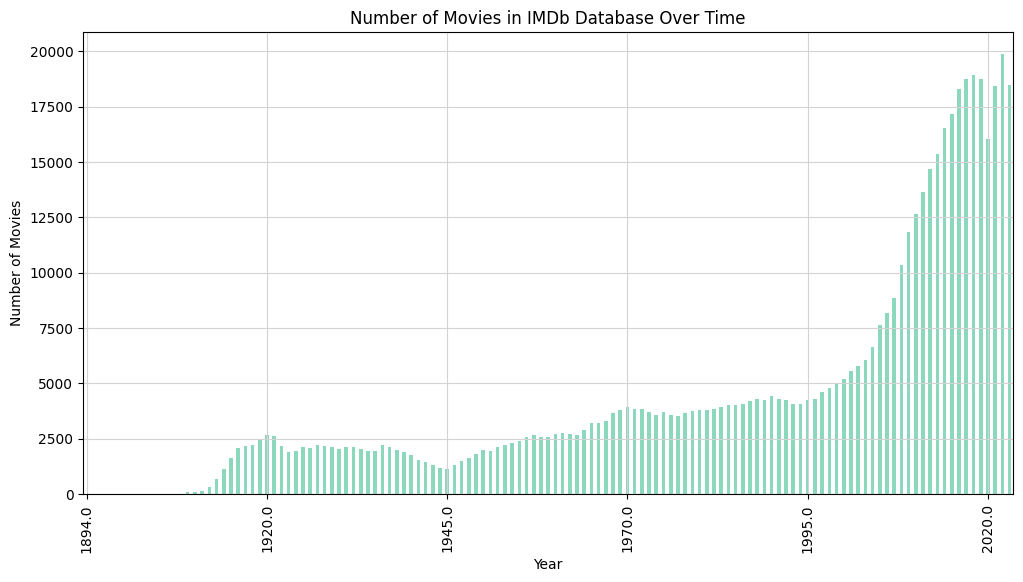

In [16]:
# Filter out movies released after 2023
movies = movies[movies['startYear'] <= 2023]

# Grouping the 'movies' DataFrame by 'startYear' and counting the number of movies in each year
movies_per_year = movies.groupby('startYear').size()

# Plotting the number of movies over time as a line chart
plt.figure(figsize=(12,6))
movies_per_year.plot(kind='bar', color='#8BD8BD')
plt.title('Number of Movies in IMDb Database Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(range(0, len(movies_per_year), 25), labels=movies_per_year.index[::25]) # Adjust x-axis to show labels for every 25 years
plt.grid(True, color='#D3D3D3')  # Adding light grey grid lines for better readability
plt.show()


A lot more movies are made in the 21st century than previous centuries. This is probably due to technological advancements, increased access to filmmaking tools, and the growth of digital distribution platforms, making it easier than ever to produce and share movies. Now, let's filter our dataset to include only movies released between 2000 and 2023 and see how many movies we have. 

In [17]:
# Filtering the 'movies' DataFrame to include only movies from the year 2000 onward
movies_2000_2023 = movies[(movies['startYear'] >= 2000) & (movies['startYear'] <= 2023)]

# Counting the number of unique values in each column of the 'movies_2000_onward' DataFrame
movies_2000_2023.nunique()

tconst       313644
startYear        24
genres         1193
dtype: int64

In [18]:
# Displaying the first few rows of the 'movies_2000_2023' DataFrame
movies_2000_2023.head()

,tconst,startYear,genres
11634,tt0011801,2019.0,"Action,Crime"
13079,tt0013274,2021.0,Documentary
15174,tt0015414,2000.0,\N
27745,tt0028248,2022.0,Musical
34798,tt0035423,2001.0,"Comedy,Fantasy,Romance"


We now have 313,644 movies made between 2000 and 2023, with information on each movie's ID (`tconst`), release year (`startYear`), and genres (`genres`). Before moving on to the next stage of analysis, we save this dataset to a CSV file so that we can use it later to construct a dynamic collaboration network among film-makers from 2000 to 2023. 

In [15]:
# Saving the DataFrame to a CSV file for future use
# 'index=False' omits the index column in the saved file
movies_2000_2023.to_csv('movies_2000_2023.csv', index=False)

# Tracing career path of first-time directors

In this section, we focus on identifying directors who made their directorial debut between 2003 and 2013. And then, we gather data on the movies they directed throughout their career.

Let's start by examining the `df_principals` DataFrame, which contains information on key personnel involved in each movie. Let's also take a quick look at the `category` to understand the different roles present in the dataset.

In [11]:
# Displaying the first few rows of the 'df_principals' DataFrame to examine its structure
df_principals.head()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N


In [12]:
# Counting and displaying the frequency of each role (category) in the 'df_principals' DataFrame
df_principals['category'].value_counts()

category
actor                  13320366
self                   10445829
actress                10390563
writer                  8434560
director                6949679
producer                3916757
cinematographer         2050550
editor                  1996781
composer                1996435
archive_footage          397774
production_designer      381792
archive_sound              4515
Name: count, dtype: int64

The data includes information on who (`nconst`) worked on which movie (`tconst`) in which capacity (`category`). Since the aim of the project is to examine the effects of networks for individuals in leadership positions, we filter the DataFrame to include only directors, who shape the artistic and creative vision of a movie.

To identify directors whose first movie was released between 2003 and 2013, we merge the `directors` data with the `movies` data (from the previous section) based on the movie ID (`tconst`'). We group the data by director ID (`nconst`) and find the earliest movie for each director. We then filter for directors whose first movie was between 2003 and 2013. With this sample of first-time directors, we then create a DataFrame called `directors_full_filmography` that contains all movies directed by these first-time directors. 

In [19]:
# Filter 'df_principals' to include only entries where the category is 'director'
# This isolates the individuals who have directed movies
directors = df_principals[df_principals['category'] == 'director']

# Merge the 'movies' DataFrame with the 'directors' DataFrame based on the 'tconst' field, 
# This links directors to the movies they directed
directors = movies.merge(directors[['tconst', 'nconst']], on='tconst', how='inner')

# Group by director ('nconst') and find the first movie for each director
# The 'agg' function aggregates the 'startYear' column to find the minimum year, i.e., the director's debut year
first_movies = directors.groupby('nconst').agg({'startYear': 'min'}).reset_index()

# Filter the results to include only directors whose first movie was released between 2003 and 2013
first_time_directors = first_movies[(first_movies['startYear'] >= 2003) & (first_movies['startYear'] <= 2013)]

# Rename the 'startYear' column to 'firstYear' to denote it as the year of the director's first movie
first_time_directors = first_time_directors.rename(columns={'startYear': 'firstYear'})

# Filter the 'directors' data to include only movies directed by the identified first-time directors
# This results in a DataFrame containing all movies directed by these directors
directors_full_filmography = directors[directors['nconst'].isin(first_time_directors['nconst'])]

# Merge the 'movies_directors' DataFrame with 'first_time_directors' to include the first year of directing
directors_full_filmography = directors_full_filmography.merge(first_time_directors, on='nconst', how='left')

Let's see how many directors we have in our data.

In [20]:
# Displaying the unique counts in the 'directors_full_filmography' DataFrame for an overview
directors_full_filmography.nunique()

tconst       115407
startYear        21
genres          948
nconst        63168
firstYear        11
dtype: int64

Our sample includes 63168 directors. Let's count the number of movies each director made in their debut year.

In [22]:
# Count Movies Directed by the Directors in Their First Year

# Filter 'directors_full_filmography' to keep only movies directed in the director's first year
first_year_movies = directors_full_filmography[directors_full_filmography['startYear'] == directors_full_filmography['firstYear']]

# Group by director ('nconst') and counting the number of movies each directed in their first year
movies_count_first_year = first_year_movies.groupby('nconst').size()

# Counting and sorting the number of directors for each movie count in their first year
movies_count_first_year.value_counts().sort_index()

1    61775
2     1276
3       83
4       22
5        7
6        3
7        2
Name: count, dtype: int64

Looks the majority (98%) of directors in our sample directed only one movie in their first year, but a small group of directors did make more than one movie the year they started directing. 

To add depth to our analysis, we merge IMDb data on ratings and number of votes with our filmography dataset. This allows us to consider the popularity and reception of each movie directed by our cohort of first-time directors. We then save this filmography data, now include directors' complete works and associated ratings, for future analysis.

In [25]:
# URL for the IMDb 'title.ratings' dataset
url_ratings = 'https://datasets.imdbws.com/title.ratings.tsv.gz'

# Read the 'title.ratings' dataset 
df_ratings = pd.read_csv(url_ratings, sep='\t', compression='gzip')

# Displaying the first few rows of 'df_ratings' for an overview
df_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2017
1,tt0000002,5.7,270
2,tt0000003,6.5,1943
3,tt0000004,5.4,178
4,tt0000005,6.2,2721


In [26]:
# Merge the ratings data with the 'directors_full_filmography' dataset
# This adds IMDb ratings and number of votes to the filmography data
directors_full_filmography = directors_full_filmography.merge(df_ratings, on='tconst', how='left')

# Save the 'directors_full_filmography' dataset to a CSV file for future use
directors_full_filmography.to_csv('directors_full_filmography.csv', index=False)

# Examining career pre and post directing debut

In this section, we delve into two key aspects of first-time directors' careers: their productivity after their directorial debut and their professional experiences prior to directing their first movie.

## Career progression post-debut:

To track the number of movies directed post-debut for each director, we create a DataFrame (`all_directors`) containing all first-time directors. We then filter the `directors_full_filmography` DataFrame to keep only the movies directed after each director's debut. Finally, we group this data by director and counting the number of movies each director went on to direct after their directoral debut.

In [42]:
# Initialize a DataFrame with all first-time directors with zero movies after debut
all_directors = directors_full_filmography[['nconst', 'firstYear']].drop_duplicates()
all_directors['movies_directed_after_first'] = 0

# Filter to keep only the movies directed after the first movie
movies_after_first = directors_full_filmography[directors_full_filmography['startYear'] > directors_full_filmography['firstYear']]

# Group by director and count the number of movies
movies_count_after_first = movies_after_first.groupby('nconst').size()

# Update the count in all_directors DataFrame
all_directors.set_index('nconst', inplace=True)
all_directors.loc[movies_count_after_first.index, 'movies_directed_after_first'] = movies_count_after_first
all_directors.reset_index(inplace=True)

Let's generate of some descriptive statistics for the number of movies directed by first-time directors after their debut.

In [41]:
all_directors['movies_directed_after_first'].describe()

count    63168.000000
mean         1.009958
std          2.359630
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        126.000000
Name: movies_directed_after_first, dtype: float64

On average, each of the 63,168 directors in our sample directed just over 1 movie after their debut. The 75th percentile (or third quartile) is also 1, meaning that 75% of the directors directed 1 or fewer movies after their debut. This suggests that most directors either made only their debut film or a few more after that. This indicates high career failure among movie directors. However, the high standard deviation indicates a significant variation in the number of movies directed post-debut among these directors. While some may have directed only a few movies, a small numbers may have had much more prolific careers.

Let's create a bar chart is created to visualize the range of post-debut productivity among directors.

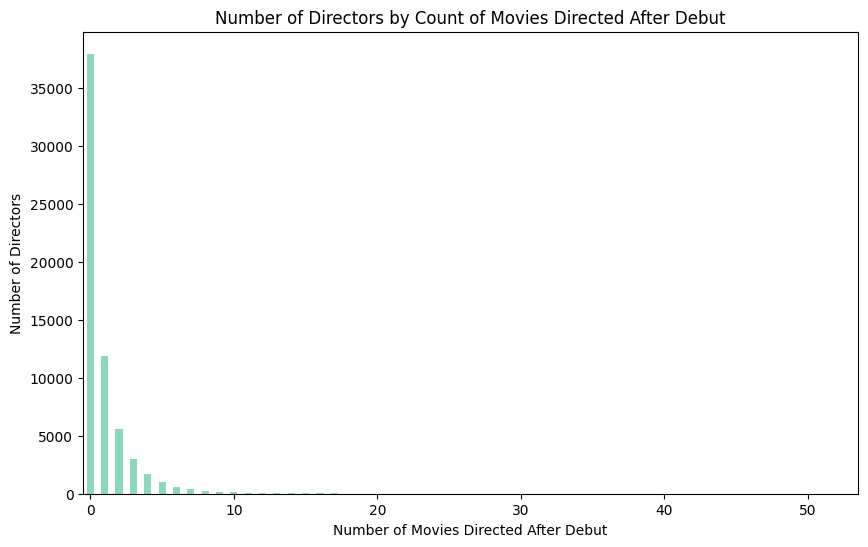

In [43]:
# Count how many directors have each number of post-debut movies
director_counts_by_movie_number = all_directors['movies_directed_after_first'].value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
director_counts_by_movie_number.plot(kind='bar', color='#8BD8BD')

# Adding labels and title
plt.title('Number of Directors by Count of Movies Directed After Debut')
plt.xlabel('Number of Movies Directed After Debut')
plt.ylabel('Number of Directors')

# Adjust x-axis to show labels for every 10 movies
# Keep the x-axis labels horizontal for readability
xticks = range(0, len(director_counts_by_movie_number), 10)
plt.xticks(ticks=xticks, labels=[str(i) for i in xticks], rotation=0)


plt.show()

## Background pre-debut

Some first-time directors might have worked on other movies before they started directing, where they took on non-directing roles. This prior experience might influence their career longevity as a director. Therefore, we will create two variables to reflect a first-time director’s prior work experience, including whether they have worked on other movies in non-directing roles before they directed their first movie, and if so, how many movies and which role they took on in these movies.

In [ ]:
# Filter for entries of the first-time directors excluding the 'director' category
all_roles = df_principals[(df_principals['nconst'].isin(first_time_directors['nconst']))]

# Merge to get the movie years
all_roles = all_roles.merge(movies[['tconst', 'startYear']], on='tconst', how='left')

# Remove rows with NA in startYear
all_roles.dropna(subset=['startYear'], inplace=True)

# Merge with first_time_directors to get the first movie year for each director
all_roles = all_roles.merge(first_time_directors, on='nconst', how='left')

# Filter for movies before their directorial debut
prior_work = all_roles[all_roles['startYear'] < all_roles['firstYear']]

# Filter for movies where they took on 'self' as their role
prior_work = prior_work[prior_work['category'] != "self"]

# Aggregate data for directors with prior experience
directors_prior_experience = prior_work.groupby('nconst').agg({
    'tconst': 'count', 
    'category': lambda x: list(set(x))
    }).rename(columns={'tconst': 'movie_count', 'category': 'roles'})

# Initialize a DataFrame with all first-time directors
all_first_time_directors = pd.DataFrame({'nconst': first_time_directors['nconst']})
all_first_time_directors['had_prior_experience'] = 0  # Initialize with 0

# Merge with directors_prior_experience
all_first_time_directors = all_first_time_directors.merge(directors_prior_experience, on='nconst', how='left')

# Update the 'had_prior_experience' column to 1 for directors who had prior experience
all_first_time_directors.loc[all_first_time_directors['movie_count'] > 0, 'had_prior_experience'] = 1

# Fill NaN values for directors without prior experience
all_first_time_directors['movie_count'].fillna(0, inplace=True)

In [ ]:
all_first_time_directors.groupby('movie_count')['nconst'].count().reset_index(name='number_of_directors')

In [ ]:
# Flatten the list of roles and count each occurrence
role_counts = directors_prior_experience.explode('roles')['roles'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
role_counts.plot(kind='bar', color='#8BD8BD')

# Adding labels and title
plt.title('Count of First-Time Directors with Prior Experience in Certain Roles')
plt.xlabel('Roles')
plt.ylabel('Number of Directors')

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()

In [ ]:
# Merge the DataFrames on 'nconst'
all_first_time_directors = all_directors.merge(all_first_time_directors, on='nconst', how='inner')



In [ ]:
all_first_time_directors.to_csv('directors_pre_post_debut_careers.csv', index=False)